# Convolutional Model of MNIST For Detection

This is the first step in messing around with the YOLO approach for object detection. This notebook goes through using FCN for detecting, locating, and predicting a MNIST number in a black background.

Start tensorboard with: python3 -m tensorflow.tensorboard --logdir=/dataset/Untitled Folder/Conv-LSTM_MNIST_Tracker_data/

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import losses
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)

Using TensorFlow backend.


In [2]:
batch_size = 24
num_classes = 10
n_steps = 5
epochs = 5

# Shape of the large images we are putting the numbers into
large_image_shape = (64,64)

# Checkpoint folder
model_data_folder = "/dataset/MNIST_Tracking/Convolutional_MNIST_Detection_data/"

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
    input_shape = (1,x_test.shape[1], x_test.shape[2])
else:
    x_train = x_train.reshape(x_train.shape[0],  x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    input_shape = (x_test.shape[1], x_test.shape[2], 1)

In [4]:
def generate_inputs(x,y,batch_size = 128, n_classes = 10, large_image_shape = (64,64),max_speed = 5):
    '''
    Using an MNIST number, make a video with the number randomly located and moving.
    
    n_classes: 10, fixed for MNIST
    large_image_shape: the shape of the output video
    max_speed: The max speed the number can travel across the frame in pixels/frame    
    
    '''      
    
    n_samples,n_rows,n_cols,n_chan = x.shape
    num_batches = np.round(float(n_samples)/float(batch_size)-.5)
    
    y = keras.utils.to_categorical(y, n_classes)
    
    while 1:
        sample_order = np.random.permutation(x.shape[0])
        x_out = np.zeros((batch_size,large_image_shape[0],large_image_shape[1],n_chan),dtype = x.dtype)
        y_out = np.zeros((batch_size,1,1,n_classes+2))
        
        location_out = np.zeros((batch_size,1,1,2))
        class_out = np.zeros((batch_size,1,1,n_classes))

        permute_counter = 0
        for ii in range(batch_size):
            permute_counter += 1
            # velocity vecotor
            velo = np.random.randint(-max_speed,max_speed,2)
            # initialize the limits on where the the number can start
            limits = np.array([[int(n_rows/2),large_image_shape[0]-int(n_rows/2)],
                               [int(n_cols/2),large_image_shape[1]-int(n_cols/2)]])
            
            if velo[0] >= 0:
                limits[0,1] = large_image_shape[0] - (int(n_rows/2) + velo[0]*n_steps)
            else:
                limits[0,0] = int(n_rows/2) - velo[0]*n_steps
                
            if velo[1] >= 0:
                limits[1,1] = large_image_shape[0] - (int(n_rows/2) + velo[1]*n_steps)
            else:
                limits[1,0] = int(n_rows/2) - velo[1]*n_steps
            
            #initialize and create starting point
            location = np.zeros((2))
            location[0] = np.random.randint(limits[0,0],limits[0,1])
            location[1] = np.random.randint(limits[1,0],limits[1,1])
            location = location.astype(np.int)
            # convert to relative distance across image
            location_out[ii,0,0,0]=location[0]/large_image_shape[0]
            location_out[ii,0,0,1]=location[1]/large_image_shape[1]
            
            x_out[ii,
                  int(location[0] - n_rows/2):int(location[0] + n_rows/2),
                  int(location[1] - n_cols/2):int(location[1] + n_cols/2),:] = x[sample_order[permute_counter]]
            
            class_out[ii,0,0,:] = y[sample_order[permute_counter]]
            
        x_out = x_out.astype(np.float32)/255.
        y_out = np.concatenate((location_out,class_out),axis=3)
        
        yield (x_out,y_out)

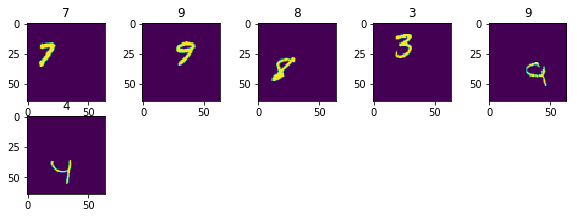

In [5]:
# Take a look at what the images look like
dev_batch_size = 6
num_batches = 1

t = generate_inputs(x_train,y_train,batch_size = dev_batch_size, n_classes = 10, large_image_shape=large_image_shape)

batch_counter = 0 
for ii in t:
    batch_counter += 1
    data = ii[0]
    n_cols = n_steps
    n_rows = dev_batch_size
    counter = 0
    img_shape = data[0,:,:,0].shape
    for jj in range(dev_batch_size):
        counter += 1
        plt.subplot(n_rows,n_cols,counter)
        plt.title('{}'.format(np.argmax(ii[1][jj,0,0,2:])))
        plt.imshow(data[jj,:,:,:].reshape(img_shape[0],img_shape[1]))
    plt.show()
    if batch_counter >= num_batches:
        break


In [6]:
def locs_loss(y_true,y_pred):
    
    # want location error of the sample image width (28x28) to be just as bad as a wrong class
    
    scale = np.log(10)/((28./64.)**2)
    locs = K.clip(y_pred[...,:2],0.,1.)
    loss = scale * losses.mean_squared_error(y_true[:,:,:,:2],locs)
    return loss

def class_loss(y_true,y_pred):
    
    classes = K.softmax(y_pred[:,:,:,2:])
    loss = losses.categorical_crossentropy(y_true[:,:,:,2:],classes)

    return loss

def custom_loss(y_true, y_pred):
    
    locs =locs_loss(y_true,y_pred)
    classes = class_loss(y_true,y_pred)
    
    loss = locs + classes
    return loss

def class_acc(y_true,y_pred):
    
    return metrics.categorical_accuracy(y_true[:,:,:,2:],y_pred[:,:,:,2:])

In [7]:
train_gen = generate_inputs(x_train,y_train,batch_size = batch_size, n_classes = 10)
test_gen = generate_inputs(x_test,y_test,batch_size = batch_size,n_classes = 10)

In [8]:
from keras.layers import Input
from keras.models import Model
main_input = Input(shape=(64,64,1),dtype='float32',name="main_input")
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name='Conv_01')(main_input)
x=MaxPooling2D(pool_size=(3,3),name="Maxpool_02")(x)
x=Conv2D(32, (3,3), activation='relu',name="Conv_03")(x)
x=MaxPooling2D(pool_size=(4,4),name="Maxpool_04")(x)

x=Conv2D(filters=12, kernel_size=(4,4),padding='valid',activation='relu',name='Conv_05')(x)

model = Model(inputs=main_input, outputs=x)

model.compile(loss=custom_loss,
              optimizer=keras.optimizers.Adadelta(),
              metrics=[class_acc,class_loss,locs_loss])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 64, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 62, 62, 32)        320       
_________________________________________________________________
Maxpool_02 (MaxPooling2D)    (None, 20, 20, 32)        0         
_________________________________________________________________
Conv_03 (Conv2D)             (None, 18, 18, 32)        9248      
_________________________________________________________________
Maxpool_04 (MaxPooling2D)    (None, 4, 4, 32)          0         
_________________________________________________________________
Conv_05 (Conv2D)             (None, 1, 1, 12)          6156      
Total params: 15,724
Trainable params: 15,724
Non-trainable params: 0
_________________________________________________________________


In [9]:
# tensorboard
#keras.callbacks.TensorBoard(log_dir=model_data_folder, histogram_freq=0,write_graph=True, write_images=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir=model_data_folder, histogram_freq=0, write_graph=True, write_images=True)

#Checkpoints
checkpointer = ModelCheckpoint(filepath=model_data_folder + 'weights.hd5', verbose=1, save_best_only=True)

#logger
csv_logger = keras.callbacks.CSVLogger(model_data_folder+"train_log.csv", separator=',', append=False)

In [10]:
model.fit_generator(train_gen,
          steps_per_epoch = np.round(x_train.shape[0]/batch_size-.5).astype('int'),
          epochs=epochs,
          verbose=1,
          validation_data=test_gen,
          validation_steps =np.round(x_test.shape[0]/batch_size-.5).astype('int'),
          callbacks=[tbCallBack,checkpointer,csv_logger])

Epoch 1/5
2500/2500 [==============================] - 27s - loss: 2.1246 - class_acc: 0.2676 - class_loss: 2.0826 - locs_loss: 0.0420 - val_loss: 1.8851 - val_class_acc: 0.3858 - val_class_loss: 1.8518 - val_locs_loss: 0.0333
Epoch 2/5
2500/2500 [==============================] - 27s - loss: 1.7258 - class_acc: 0.4363 - class_loss: 1.6917 - locs_loss: 0.0341 - val_loss: 1.5674 - val_class_acc: 0.4942 - val_class_loss: 1.5389 - val_locs_loss: 0.0286
Epoch 3/5
2500/2500 [==============================] - 26s - loss: 1.5024 - class_acc: 0.4968 - class_loss: 1.4680 - locs_loss: 0.0344 - val_loss: 1.3862 - val_class_acc: 0.5244 - val_class_loss: 1.3617 - val_locs_loss: 0.0244
Epoch 4/5
2500/2500 [==============================] - 28s - loss: 1.3618 - class_acc: 0.5236 - class_loss: 1.3314 - locs_loss: 0.0304 - val_loss: 1.2951 - val_class_acc: 0.5487 - val_class_loss: 1.2615 - val_locs_loss: 0.0336
Epoch 5/5
2500/2500 [==============================] - 28s - loss: 1.2808 - class_acc: 0.539

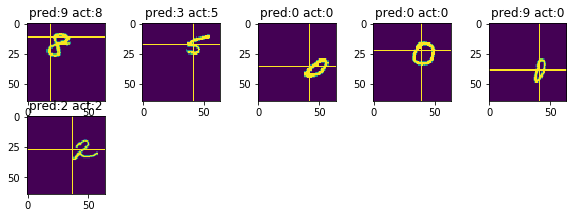

In [11]:
# Take a look at what the images look like
dev_batch_size = 6
num_batches = 1

t = generate_inputs(x_train,y_train,batch_size = dev_batch_size, n_classes = 10, large_image_shape=large_image_shape)

batch_counter = 0 
for data in t:
    batch_counter += 1
    predictions = model.predict(data[0],batch_size=dev_batch_size)

    image = data[0]
    n_cols = n_steps
    n_rows = dev_batch_size
    counter = 0
    img_shape = image[0,:,:,0].shape
    for jj in range(dev_batch_size):
        counter += 1
        #get the rows and colums of each prediction
        r = int(predictions[jj,0,0,0]*img_shape[0])
        c = int(predictions[jj,0,0,1]*img_shape[1])
        # reshape and draw the lines on the image
        img = image[jj,:,:,:].reshape(img_shape[0],img_shape[1])
        img[r,:] = 1
        img[:,c] = 1
        
        label = np.argmax(data[1][jj,0,0,2:])
        predicted = np.argmax(predictions[jj,0,0,2:])
        
        plt.subplot(n_rows,n_cols,counter)
        plt.title('pred:{} act:{}'.format(predicted,label))
        plt.imshow(img)
    plt.show()
    if batch_counter >= num_batches:
        break
